#Imports

In [ ]:
pip install chess

In [ ]:
pip install transformers

In [ ]:
pip install tabulate

In [4]:
import chess
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import tensorflow as tf
from collections import Counter
from transformers import TextDataset
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from tabulate import tabulate

In [5]:
#test if gpu is enabled
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
# bash code to mount the drive
import os
from google.colab import drive
drive.mount ("/content/drive")
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


#Remove unnecessary information from game transcripts
-> read_games.py

In [7]:
def read_games(raw_file_path, number_of_games, format="pgn", write_to_file=True, target_file_path="games.txt", startpoint=0):
    number_of_games = number_of_games + startpoint
    with open(raw_file_path, 'r') as file:
        games = []
        if format == "pgn":
            for line in file:
                if line[0] == "[": continue # remove metadata
                elif line == '\n': continue # remove empty lines
                elif "eval" in line: continue # remove evals
                elif "#" not in line: continue # remove games that are not finished by checkmate
                elif "100." in line: continue # remove games that are too long (at least 100 moves)
                else:
                    games.append(line)
                    number_of_games-=1
                if number_of_games==0: break
        elif format == "lan":
            for line in file:
                if line[0] == "[": continue # remove metadata
                elif line == '\n': continue # remove empty lines
                else:
                    games.append(line)
                    number_of_games-=1
                if number_of_games==0: break
    
    games = games[startpoint:]

    if write_to_file:
        with open(target_file_path, 'w') as file:
            file.write(str(games))
    else:
        return games

#Create Dataset
-> create_dataset.py

In [8]:
def create_dataset(file_path, tokenizer, block_size=96): # create dataset from games
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
        overwrite_cache = True
    )
    return dataset

#Train model
-> model.py

In [9]:
class Model:
    def __init__(self, model_name):
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.data_collator = self.load_data_collator(self.tokenizer)

    def load_data_collator(self, tokenizer):
        return DataCollatorForLanguageModeling(
            tokenizer=tokenizer, 
            mlm=False
        )

    def train(self, train_dataset, eval_dataset, output_dir, per_device_train_batch_size, num_train_epochs, save_steps):
        '''
        POTENTIALLY NEEDS TO BE UPDATED TO INCLUDE A VALIDATION DATASET
        save_steps: number of steps after which a copy of the model is saved, might be useful for evaluation
        '''
        self.tokenizer.save_pretrained(output_dir)
        self.model.save_pretrained(output_dir)

        training_args = TrainingArguments(
            output_dir=output_dir,
            overwrite_output_dir=True,
            per_device_train_batch_size=per_device_train_batch_size,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
            warmup_steps=1000
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            data_collator=self.data_collator,
            train_dataset=train_dataset,
            eval_dataset = eval_dataset  #QUESTION: For what is this currently used in Trainer?
        )

        trainer.train()
        trainer.save_model()

    def load(self, model_dir):
        '''
        Load a trained model from directory
        '''
        self.model = GPT2LMHeadModel.from_pretrained(model_dir)
        #self.tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

    def generate(self, prompt, max_new_tokens, num_return_sequences):
        '''
        prompt: string in LAN or PGN notation
        max_new_tokens: maximum number of tokens to generate (for PGN min. 6, for LAN 1). Set this to a high value to generate a full game or longer move sequences
        num_return_sequences: number of possible sequences of moves to return
        '''
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt')
        beam_output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            num_beams=5,
            num_return_sequences=num_return_sequences,
            temperature=1.0,
            pad_token_id=self.model.config.eos_token_id,
            top_k=50,
            top_p=0.95
        )
        return [self.tokenizer.decode(beam, skip_special_tokens=True, clean_up_tokenization_spaces=True) for beam in beam_output]


    def generate_legal_move(self, prompt, board):
        '''
        Uses constrained beam search and board evaluation to generate a single legal move.
        Can only output one move because of the legality check, use generate() for multiple moves.
        This is deterministic and does not allow for sampling.
        '''
        legal_moves = [board.uci(move) for move in list(board.legal_moves)]
        force_words_ids = [self.tokenizer(legal_moves, add_prefix_space=True, add_special_tokens=False).input_ids]
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt')

        beam_output = self.model.generate(
            input_ids,
            force_words_ids=force_words_ids,
            max_new_tokens=1,
            num_beams=10,
            num_return_sequences=1,
            temperature=1.0
        )
        return self.tokenizer.decode(beam_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)


    def add_vocab(self, vocab_file):
        '''
        Add missing tokens to the vocabulary (used for LAN tokens)
        '''
        with open(vocab_file, "r") as file:
            vocab = file.read().splitlines()
        print("Tokens to be added: ", len(set(vocab) - set(self.tokenizer.get_vocab())))
        self.tokenizer.add_tokens(list(set(vocab) - set(self.tokenizer.get_vocab())))
        self.model.resize_token_embeddings(len(self.tokenizer))
        print("New vocabulary size: ", len(self.tokenizer))

-> test_train_model.py

In [10]:
"""NEW VERSION"""

#instantiate model
model = Model(model_name='gpt2')
print("Instantiated model")

#create datasets
games_train = read_games(raw_file_path="/content/drive/MyDrive/Chess/lichess_db_2015-08.pgn", number_of_games=10000, format="pgn", write_to_file=True, target_file_path="games_train.txt", startpoint=0)
games_eval = read_games(raw_file_path="/content/drive/MyDrive/Chess/lichess_db_2013-01.pgn", number_of_games=50, format="pgn", write_to_file=True, target_file_path="games_eval.txt", startpoint=0)
print("Read games")
train_ds = create_dataset(file_path="games_train.txt", tokenizer=model.tokenizer, block_size=96)
eval_ds = create_dataset(file_path="games_eval.txt", tokenizer=model.tokenizer, block_size=96)
print("Created datasets")

#train model
model.train(train_dataset=train_ds, eval_dataset=eval_ds, output_dir="model_100k", per_device_train_batch_size=32, num_train_epochs=5, save_steps=1000)
print("Model trained")

Instantiated model
Read games


/usr/local/lib/python3.9/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Created datasets


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.678200
1000,1.358800
1500,1.268100
2000,1.223000
2500,1.193200
3000,1.170300
3500,1.161400
4000,1.148200


Model trained


#Evaluation

In [11]:
import random

def extract_start(game, stop_move):
  """
  Extracts the game until a predefined move
    - game = game in SAN notation
    - stop_move = move number indicating end of extraction
  """
  #find beginning of stop move
  loc = game.find(' ' + str(stop_move) + '. ')
  #return opening
  if loc == -1:
    return game
  return game[:loc]

def generate_common_openings(num_games, training_data):
  """
  Finds common game openings (of training data) needed for model evaluation 1
    - num_games = amount of openings needed
    - training_data = all games used for training the model
  """
  openings = []
  for game in training_data:
    #get game opening, i.e. first and second move
    opening = extract_start(game=game, stop_move=3)
    #add opening 
    openings.append(opening)
  #count opening occurrences 
  occ = Counter(openings)
  occ_sorted = Counter(occ)
  #select most common openings as startpositions
  eval_startpos = occ_sorted.most_common(num_games)
  #remove the count
  eval_startpos = [pos for pos,count in eval_startpos]
  return eval_startpos
  

def generate_startpos(num_games, num_moves, testing_data):
  """
  Generates all start positions needed for model evaluation 2 and 3
    - num_games = amount of games on which model is tested
    - num_moves = amount of moves taken to get start position of game
    - testing_data = human games that the model has not seen yet
  """
  eval_startpos = []
  for game in testing_data[:num_games]:
    #get first moves of game
    opening = extract_start(game=game, stop_move=num_moves+1)
    #add start position
    eval_startpos.append(opening)
  return eval_startpos

def get_random_state(num_moves):
  """
  Generates a random game state after a predefined number of moves
    - num_moves = amount of moves taken
  """
  move_seq = ''
  #create a new chess board
  board = chess.Board()
  #generate random moves in SAN notation
  for i in range(num_moves):
    w_move = ''
    b_move = ''
    for player in range(2):
      #get all legal moves of current board state
      legal = list(board.legal_moves)
      #make random move + save its SAN
      move = random.choice(legal)
      if player == 0: #white
        w_move = board.san(move)
      else: #black
        b_move = board.san(move)
      board.push(move)
    #add move to move sequence
    move_seq = move_seq + f"{i+1}. " + w_move + ' ' + b_move + ' '
  return move_seq

def generate_random_startpos(num_games, num_moves):
  """
  Generates all start positions needed for model evaluation 4 and 5
    - num_games = amount of games on which model is tested
    - num_moves = amount of moves taken to get start position of game
  """
  eval_startpos = []
  for game in range(num_games):
    #generate and add random start position
    move_seq = get_random_state(num_moves)
    eval_startpos.append(move_seq)
  return eval_startpos

In [65]:
def create_table(data1, data2, data3):
  """
    Visualizes data in a table
      - data1 = amount of valid moves of each generated game
      - data2 = illegal move (in SAN) of each generated game
      - data3 = type of illegal move of each generated game
    Requirement: data1, data2 and data3 are of similar size
  """
  #transpose data to compare models for each evaluation (instead of evaluations for each model)
  data1 = list(zip(*data1))
  data2 = list(zip(*data2))
  data3 = list(zip(*data3))
  #create column headings of table
  table_data = [['Evaluation', 'Model', 'Amount valid moves', 'Illegal move', 'Type of Illegal move']]
  #add data to table
  for e in range(len(data1)):
    for m in range(len(data1[0])):
      table_data.append([e+1, m+1, data1[e][m], data2[e][m], data3[e][m]])
    #add empty row between data of different evaluations
    table_data.append(['','','','',''])
  #create table
  print(tabulate(table_data, headers='firstrow'))

In [13]:
def create_graph(steps, data):
  """
    Creates a graph that visualizes all five evaluation results over training time
      - steps = list of all models # of training steps, after which they were saved
      - data = data containing the results of each evaluation
    Restriction: can only visualize 5 evaluation criteria
  """
  #transpose data to compare models for each evaluation (instead of evaluations for each model)
  data = list(zip(*data))
  #plot the values
  plt.plot(steps, data[0], label="from opening position of known human game")
  plt.plot(steps, data[1], label="from position after move 5 of human game")
  plt.plot(steps, data[2], label="from position after move 10 of human game")
  plt.plot(steps, data[3], label="from position after move 5 of artificial game")
  plt.plot(steps, data[4], label="from position after move 10 of artificial game")
  #prepare plot
  plt.title('Performance of model trained on 10 000 games')
  plt.xlabel('Steps')
  plt.ylabel('Average amount of legal moves generated*')
  plt.legend(bbox_to_anchor=(1.05, 1))
  plt.annotate('* Mean value was drawn from 5 generated games',
              xy = (1.82, 0.5),
              xycoords='axes fraction',
              ha='right',
              va="center",
              fontsize=10)
  #show plot
  plt.show()

In [70]:
def prepare_startpos(seq):
  """
    Removes the move count of the input sequence and splits it into single moves
      - seq = single input sequence in SAN
  """
  #split sequence into moves
  moves_with_nr = seq.split()
  #remove move count
  moves = np.array(moves_with_nr)
  moves = np.delete(moves, np.arange(0, moves.size, 3))
  return moves_with_nr, moves

def generate_game(model, tokenizer, startpos, n_tokens):
  """
    Model generates a game of a predefined number of moves from a given startposition
      - model = model used to generate game
      - tokenizer = tokenizer used for encoding and decoding
      - startpos = single input sequence
      - n_tokens = amount of tokens that should be generated
  """
  #get amount of chars in startposition
  n_chars = sum(len(x) for x in startpos) #ERASE???
  #prepare prompt: convert list back into single string
  prompt = ' '.join(startpos)
  #generate game
  output = model.generate(prompt=prompt,max_new_tokens=30,num_return_sequences=1) #instead write "n_chars+n_tokens" + change n_moves to n_tokens in function calls
  #split game into moves
  output = output[0].split(" ")
  #remove startposition
  output = output[len(startpos):]
  #remove last move to avoid potential incompleteness of the moves
  idx = max(idx for idx, x in enumerate(output) if '.' in x)
  output = output[:idx]
  #remove move numbers
  game = [ x for x in output if "." not in x ]
  return game, output

def validation(n_valid, model, tokenizer, startpos, n_moves, board):
  """
    Generates game until first illegal move, returns # of legal moves and illegal move in SAN
      - n_valid = current amount of valid moves generated
      - model = model used to generate game
      - tokenizer = tokenizer used for encoding and decoding
      - startpos = single input sequence leading to current board state in SAN
      - n_moves = amount of moves that should be generated
      - board = chess board object
  """
  valid = True
  #generate game 
  moves, movesWnr = generate_game(model, tokenizer, startpos, n_moves)
  #check generated moves
  for move in moves:
    #check if move notation is legal
    try:
      p_move = str(board.parse_san(move))
    except (chess.IllegalMoveError, chess.AmbiguousMoveError, chess.InvalidMoveError):
      illegal_move = move
      type_illegal = "Wrong notation"
      valid = False
      break
    #find all legal moves in current position
    legal = [move.uci() for move in board.legal_moves]
    #check if move is possible at current board state
    if p_move in legal:
      n_valid += 1
      board.push_san(move)
    else:
      illegal_move = move
      type_illegal = "Wrong arrangement"
      valid = False
      break
  #generate + check more moves if necessary
  if valid == True:
    #update start position
    startpos = startpos+movesWnr
    #recursion
    n_valid, illegal_move, type_illegal = validation(n_valid, model, tokenizer, startpos, n_moves, board)
  return n_valid, illegal_move, type_illegal

def test_game(model, tokenizer, startpos, n_moves):
  """
    Testing the model on a specific input
       - model = model that gets tested
       - tokenizer = tokenizer used for encoding and decoding
       - startpos = single input sequence
       - n_moves = amount of moves that should be generated
  """
  n_valid = 0
  board = chess.Board()
  #prepare start position sequence
  startpos_with_nr, startpos = prepare_startpos(startpos)
  #generate start position
  for move in startpos:
    board.push_san(move)
  #check generated game
  n_valid, illegal_move, type_illegal = validation(n_valid, model, tokenizer, startpos_with_nr, n_moves, board)
  return n_valid, illegal_move, type_illegal

def test(model, tokenizer, startpos, n_moves):
  """
    Testing the model on all start positions of a evaluation metric
       - model = model that gets tested
       - tokenizer = tokenizer used for encoding and decoding
       - startpos = (multiple) input sequences
       - n_moves = amount of moves that should be generated
  """
  global_n_valid = []
  global_illegal_move = []
  global_type_illegal = []
  #test model on each startposition
  for pos in startpos:
    n_valid, illegal_move, type_illegal = test_game(model, tokenizer, pos, n_moves)
    global_n_valid.append(n_valid)
    global_illegal_move.append(illegal_move)
    global_type_illegal.append(type_illegal)
  #calculate average # of valid moves
  avg_valid = sum(global_n_valid) / len(global_n_valid)
  return avg_valid, global_n_valid, global_illegal_move, global_type_illegal

def eval(train_ds, test_ds, model, tokenizer, n_moves, startpos):
  """
    Evaluation of one model at a specific training time
      - train_ds = dataset containing training data
      - test_ds = dataset containing test data
      - model = model that was saved during training
      - tokenizer = tokenizer used for encoding and decoding
      - n_moves = amount of moves that should be generated
      - startpos = list of all start positions
  """
  #test the model on all startpositions
  print("Start test for eval 1")
  eval1, global_n_valid1, global_illegal_move1, global_type_illegal1 = test(model, tokenizer, startpos[0], n_moves)
  print("Start test for eval 2")
  eval2, global_n_valid2, global_illegal_move2, global_type_illegal2 = test(model, tokenizer, startpos[1], n_moves)
  print("Start test for eval 3")
  eval3, global_n_valid3, global_illegal_move3, global_type_illegal3 = test(model, tokenizer, startpos[2], n_moves)
  print("Start test for eval 4")
  eval4, global_n_valid4, global_illegal_move4, global_type_illegal4 = test(model, tokenizer, startpos[3], n_moves)
  print("Start test for eval 5")
  eval5, global_n_valid5, global_illegal_move5, global_type_illegal5 = test(model, tokenizer, startpos[4], n_moves)
  #combine data for simplicity
  evals = [eval1, eval2, eval3, eval4, eval5]                                                                                          #contains average # of valid moves for all evaluation metrics
  global_n_valid = [global_n_valid1, global_n_valid2, global_n_valid3, global_n_valid4, global_n_valid5]                               #contains # of valid moves of each generated game
  global_illegal_move = [global_illegal_move1, global_illegal_move2, global_illegal_move3, global_illegal_move4, global_illegal_move5] #contains illegal move of each generated game
  global_type_illegal = [global_type_illegal1, global_type_illegal2, global_type_illegal3, global_type_illegal4, global_type_illegal5] #contains the type of illegal move of each generated game
  return evals, global_n_valid, global_illegal_move, global_type_illegal

def global_eval(train_ds, test_ds, models, tokenizer, n_moves, steps):
  """
    Evaluation of all models
      - train_ds = dataset containing training data
      - test_ds = dataset containing test data
      - models = list of all models that were saved during training
      - tokenizer = tokenizer used for encoding and decoding
      - n_moves = amount of moves that should be generated
      - steps = list of # of training steps each model was trained on
  """
  m_evals = []
  m_global_n_valid = []
  m_global_illegal_move = []
  m_global_type_illegal = []
  #create startpositions for model evaluation
  eval1_startpos = generate_common_openings(num_games=5, training_data=train_ds)
  eval2_startpos = generate_startpos(num_games=5, num_moves=5, testing_data=test_ds)
  eval3_startpos = generate_startpos(num_games=5, num_moves=10, testing_data=test_ds)
  eval4_startpos = generate_random_startpos(num_games=5, num_moves=5)
  eval5_startpos = generate_random_startpos(num_games=5, num_moves=10)
  #combine all start positions for simplicity
  startpos = [eval1_startpos, eval2_startpos, eval3_startpos, eval4_startpos, eval5_startpos]
  print("All startpositons: [eval1,eval2,eval3,eval4,eval5]")
  print(startpos)
  print()
  print("----------------------Until here works fine------------------------------" + "\n")
  #evaluate all models
  for model in models:
    print("Evaluate new model"+"\n")
    evals, global_n_valid, global_illegal_move, global_type_illegal = eval(train_ds, test_ds, model, tokenizer, n_moves, startpos)
    #save data
    m_evals.append(evals)
    m_global_n_valid.append(global_n_valid)
    m_global_illegal_move.append(global_illegal_move)
    m_global_type_illegal.append(global_type_illegal)
    print("Done evaluating current model"+"\n"+"--------------------------------"+"\n")
  print("Done with evaluating models"+"\n")
  #visualization
  create_graph(steps, m_evals)
  create_table(m_global_n_valid, m_global_illegal_move, m_global_type_illegal)

Loaded saved models
[<__main__.Model object at 0x7f99f591afa0>, <__main__.Model object at 0x7f99f591afa0>]

Train_ds: 
['1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. d4 exd4 5. Nxd4 Bd7 6. Nxc6 Bxc6 7. Bxc6+ bxc6 8. O-O Be7 9. c4 Nf6 10. Nc3 O-O 11. Re1 h6 12. Be3 Re8 13. b3 Ng4 14. Bc1 Bf6 15. Bb2 d5 16. Qxg4 d4 17. Ne2 c5 18. Ng3 d3 19. Bxf6 Qxf6 20. Rad1 Qc3 21. Nf5 Rad8 22. Nxh6+ Kh7 23. Nf5 d2 24. Re3 Qf6 25. Rh3+ Kg8 26. Qh5 g6 27. Qh7+ Kf8 28. Qh8+ Qxh8 29. Rxh8# 1-0\n', '1. e4 c5 2. Nf3 d6 3. Nc3 Nf6 4. d4 cxd4 5. Qxd4 Nc6 6. Qe3 g6 7. Bd2 Bg7 8. O-O-O O-O 9. Bc4 a6 10. Ng5 e6 11. f4 b5 12. Be2 b4 13. Na4 a5 14. Rhf1 Bd7 15. f5 exf5 16. exf5 Ne5 17. fxg6 Nxg6 18. Nb6 Rb8 19. Nxd7 Qxd7 20. h3 h6 21. Bg4 Qc7 22. Ne4 Nd5 23. Qf3 Ne5 24. Qf5 a4 25. Ng5 b3 26. axb3 axb3 27. Qh7# 1-0\n']
Test_ds: 
['1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0\n', '1. e4 g6 2. d4 d6 3. Nf3 c6 4. h3 Nf6 5. Bg5 Nx

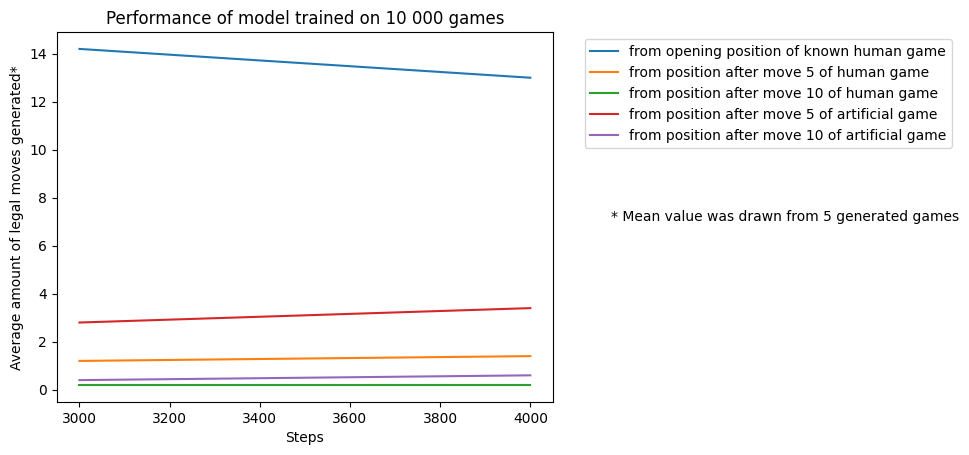

Evaluation    Model    Amount valid moves    Illegal move                             Type of Illegal move
------------  -------  --------------------  ---------------------------------------  ------------------------------------------------------------------------------------------
1             1        [11, 17, 16, 20, 7]   ['O-O', 'Bxd5', 'Bxd5', 'Nxd4', 'Nxd7']  ['Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation']
1             2        [15, 11, 13, 19, 7]   ['Nxc3', 'Nc6', 'Re7', 'Bg7', 'Nxd7']    ['Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation']

2             1        [1, 0, 5, 0, 0]       ['Nf5', 'Nxe4', 'Nxd4', 'Nf3', 'Qe2']    ['Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation']
2             2        [5, 0, 2, 0, 0]       ['Bd7', 'Nxe4', 'Nxc6', 'Nf3', 'Qe2']    ['Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation', 'Wrong notation']

3     

In [71]:
"""NEW CODE"""
#define checkpoints
checkpoints = [3000,4000]

#load saved models
models = []
for step in range(len(checkpoints)):
  model_dir = "./model_100k/checkpoint-" + str(checkpoints[step])
  model.load(model_dir)
  models.append(model)
print("Loaded saved models")
print(models)
print()

#evaluate models
train_ds = read_games("/content/drive/MyDrive/Chess/lichess_db_2015-08.pgn", 10000, write_to_file=False, target_file_path="games_train.txt")
print("Train_ds: ")
print(train_ds[:2])
test_ds = read_games("/content/drive/MyDrive/Chess/lichess_db_2013-01.pgn", 50, write_to_file=False, target_file_path="games_test.txt")
print("Test_ds: ")
print(test_ds[:2])
print()
global_eval(train_ds, test_ds, models, model.tokenizer, 10, checkpoints)


#Info Evaluation
##Data Evaluation
- What is the average game length of uncutted games in training data? What is the distribution of cutted versus uncutted games in training data?
- What are most frequent openings used in training data games? Compare frequency ranking with list of common openings found in the internet.
- How often do special moves (e.g. castling kingside/queenside, pawn promotion, check, checkmate) occur?

## Evaluation of game correctness
- What are the illegal moves? Where do most errors occur (e.g. King moves)
- How early do illegal moves occur in generated game?

##Evaluation of general game generation
- In comparison to training data, how often do special moves occur in generated games?
- Does the model generate repetitive play (within a game AND between different games, i.e. similar move decisions, outcome, etc.)? 
- Does the model generate a game ending with a result? (Yes/No)
- Does the model generate back-and-forth play between 2 players? (Yes/No)